In [1]:
import numpy as np
import matplotlib.pyplot as plt

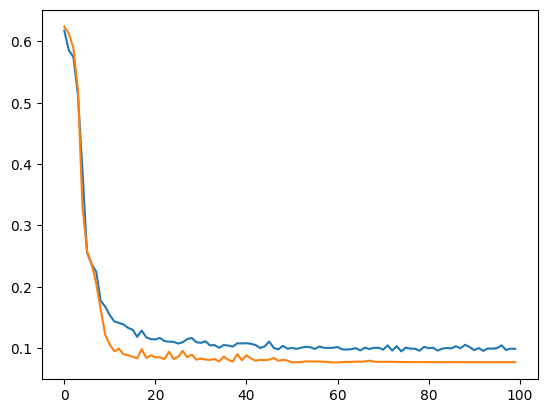

In [2]:
train_loss_curve = np.load("./ckpt/train_loss_curve.npy")
test_loss_curve = np.load("./ckpt/test_loss_curve.npy")

plt.plot(train_loss_curve, label="train")
plt.plot(test_loss_curve, label="test")

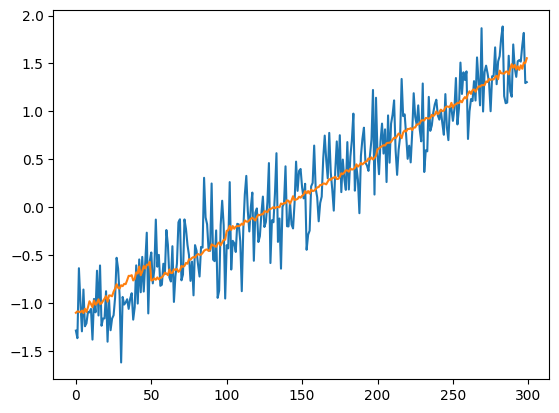

In [3]:
y = np.load("./ckpt/y.npy")
y_ = np.load("./ckpt/y_.npy")

plt.plot(y, label="y")
plt.plot(y_, label="y_")    

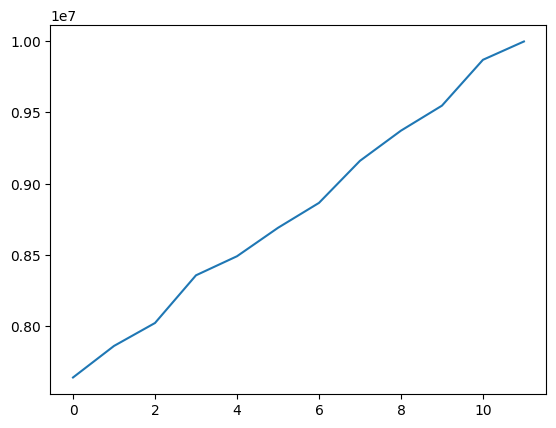

In [4]:
month_count = np.load("./data/month_count.npy")
month_day_count = np.load("./data/month_day_count.npy")
day_average = month_count/month_day_count
plt.plot(day_average, label="month_count")